In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, learning_curve

import os, shutil, joblib

import upsilon

-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


In [7]:
list_cephs = pd.DataFrame(os.listdir('../csv_data/SMC/cep/I/'))
list_bin = pd.DataFrame(os.listdir('../csv_data/SMC/bin/I/'))

# Normal
med_list_cephs = list_cephs.sample(frac = 0.3)[0].to_list() # 1396.8
med_list_bin = list_bin.sample(frac = 0.3)[0].to_list() # 11443.8

small_list_cephs = list_cephs.sample(frac = 0.1)[0].to_list() # 465.6
small_list_bin = list_bin.sample(frac = 0.1)[0].to_list() # 3814.6

small_micro_list_cephs = list_cephs.sample(frac = 0.03932260263199287)[0].to_list() # 183
small_micro_list_bin = list_bin.sample(frac = 0.03932260263199287)[0].to_list() # 1500

micro_list_cephs = list_cephs.sample(frac = 0.02)[0].to_list() # 93.12
micro_list_bin = list_bin.sample(frac = 0.02)[0].to_list() # 762.92

max_ceph = len(list_cephs)

# Balanced
balanced_large_list_cephs = list_cephs.sample(max_ceph)[0].to_list() # 4656
balanced_large_list_bin = list_bin.sample(max_ceph)[0].to_list() # 4656

balanced_med_list_cephs = list_cephs.sample(int(np.round(max_ceph * 0.7)))[0].to_list() # 4656 * 0.3 | 30%
balanced_med_list_bin = list_bin.sample(int(np.round(max_ceph * 0.7)))[0].to_list() #  4656 * 0.3  | 30%

balanced_small_list_cephs = list_cephs.sample(int(np.round(max_ceph * 0.3)))[0].to_list() # 4656 * 0.05 | 0.05%
balanced_small_list_bin = list_bin.sample(int(np.round(max_ceph * 0.3)))[0].to_list() # 4656 * 0.05   | 0.05%


balanced_micro_list_cephs = list_cephs.sample(int(np.round(max_ceph * 0.1)))[0].to_list() 
balanced_micro_list_bin = list_bin.sample(int(np.round(max_ceph * 0.1)))[0].to_list() 

list_cephs = os.listdir('../csv_data/SMC/cep/I/')
list_bin = os.listdir('../csv_data/SMC/bin/I/')[:len(list_cephs)]

### Feature extraction

In [233]:
df_list_cepheids = []

for file in list_cephs:
    file_path = "../csv_data/SMC/cep/I/" + file

    with open(file_path, 'r') as f:
        data = pd.read_table(f, delim_whitespace=True, names=["HJD-2450000", 'mag', 'err'])
        if not data.empty:
        # Modify table
            data = data.rename(columns={"HJD-2450000": "time"})

            # Convert the columns to NumPy arrays
            time = data['time'].to_numpy()
            mag = data['mag'].to_numpy()
            err = data['err'].to_numpy()

            # Create an ExtractFeatures object and extract features
            e_features = upsilon.ExtractFeatures(time, mag, err)
            e_features.run()
            features = e_features.get_features()

            # Create a DataFrame with features and class
            feature_data = pd.DataFrame.from_dict(features, orient = 'index').T.drop(columns=['period_log10FAP'])

            feature_data['id'] = file
            feature_data['class'] = 'Cepheid'

            # Append to the list of DataFrames
            df_list_cepheids.append(feature_data)


df_list_bin = []

for file in list_bin:
    file_path = "../csv_data/SMC/bin/I/" + file

    with open(file_path, 'r') as f:
        data = pd.read_table(f, delim_whitespace=True, names=["HJD-2450000", 'mag', 'err'])
        if not data.empty:
        # Modify table
            data = data.rename(columns={"HJD-2450000": "time"})

            # Convert the columns to NumPy arrays
            time = data['time'].to_numpy()
            mag = data['mag'].to_numpy()
            err = data['err'].to_numpy()

            # Create an ExtractFeatures object and extract features
            e_features = upsilon.ExtractFeatures(time, mag, err)
            e_features.run()
            features = e_features.get_features()

            # Create a DataFrame with features and class
            feature_data = pd.DataFrame.from_dict(features, orient = 'index').T.drop(columns=['period_log10FAP'])

            feature_data['id'] = file
            feature_data['class'] = 'Binary'

            # Append to the list of DataFrames
            df_list_bin.append(feature_data)

c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Program

In [234]:
# Concatenate all DataFrames into a single DataFrame
cephs = pd.concat(df_list_cepheids)
bins = pd.concat(df_list_bin)

final_df = pd.concat([cephs, bins], ignore_index=True)

# Save the DataFrame to a CSV file
final_df.to_csv(f'../csv_data/temp/test.csv', index=False)

## Model training and testing

In [14]:
df = pd.read_csv('../csv_data/main_data/lc_data.csv')
features = df.drop(columns = ['id', 'class'])
labels = df.pop('class')

from sklearn.preprocessing import LabelBinarizer
# Create a LabelBinarizer object
lb = LabelBinarizer()

# Binarize the label array
binarized_labels = lb.fit_transform(labels).ravel()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, binarized_labels, test_size=0.3)

if 'rand_forest_model.joblib' not in os.listdir('../models/'):
    cls = RandomForestClassifier(random_state=42)
    rand_forest = cls.fit(X_train, y_train)
    y_pred_test = rand_forest.predict(X_test)
    y_pred_train = rand_forest.predict(X_train)
    joblib.dump(rand_forest, 'rand_forest_model.joblib')
else:
    rand_forest = joblib.load('../models/rand_forest_model.joblib')
    y_pred_test = rand_forest.predict(X_test)
    y_pred_train = rand_forest.predict(X_train)

In [12]:
print('Train data')
print(classification_report(y_train, y_pred_train))
print('Test data')
print(classification_report(y_test, y_pred_test))

Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3452
           1       1.00      1.00      1.00      3451

    accuracy                           1.00      6903
   macro avg       1.00      1.00      1.00      6903
weighted avg       1.00      1.00      1.00      6903

Test data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1479
           1       1.00      1.00      1.00      1480

    accuracy                           1.00      2959
   macro avg       1.00      1.00      1.00      2959
weighted avg       1.00      1.00      1.00      2959



               Feature  Importance
4             kurtosis    0.217807
17            skewness    0.194934
5             n_points    0.123354
3         hl_amp_ratio    0.116732
7           period_SNR    0.073611
10           phase_eta    0.061357
20           stetson_k    0.044015
21       weighted_mean    0.039096
13          quartile31    0.030198
16           shapiro_w    0.028663
14                 r21    0.016530
6               period    0.007216
15                 r31    0.007077
19         slope_per90    0.007066
9          phase_cusum    0.006497
0            amplitude    0.006380
18         slope_per10    0.006047
8   period_uncertainty    0.004394
22        weighted_std    0.004146
1                cusum    0.001677
2                  eta    0.001424
11               phi21    0.001233
12               phi31    0.000546


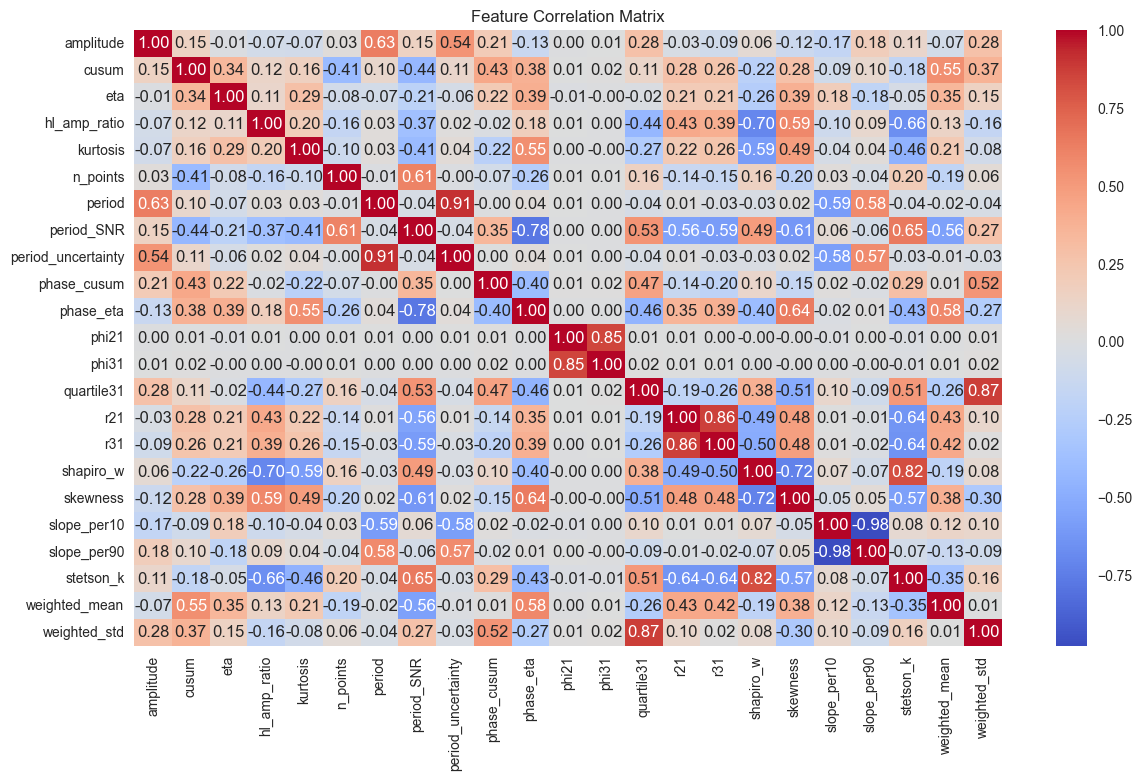

In [97]:
if isinstance(rand_forest, RandomForestClassifier):
    importances = rand_forest.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)  # Display feature importances if needed

# Create a correlation matrix
correlation_matrix = features.corr()

# Plotting the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

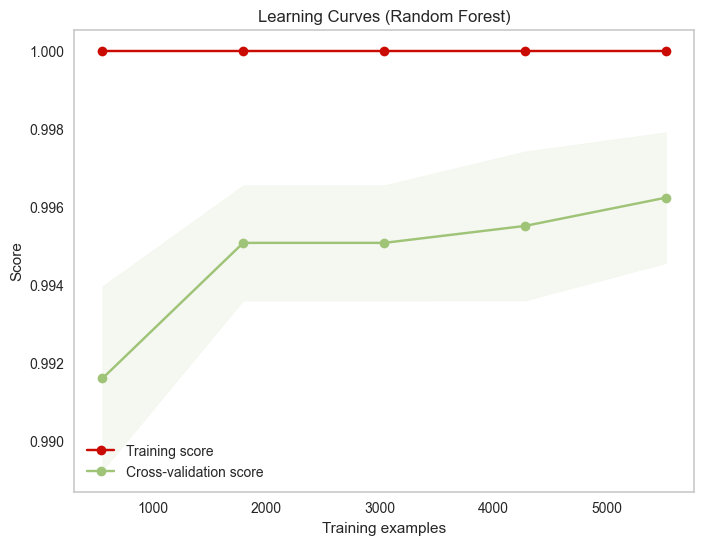

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# Function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plotting the learning curve
title = "Learning Curves (Random Forest)"
plot_learning_curve(rand_forest, title, X_train, y_train, cv=5)
plt.show()


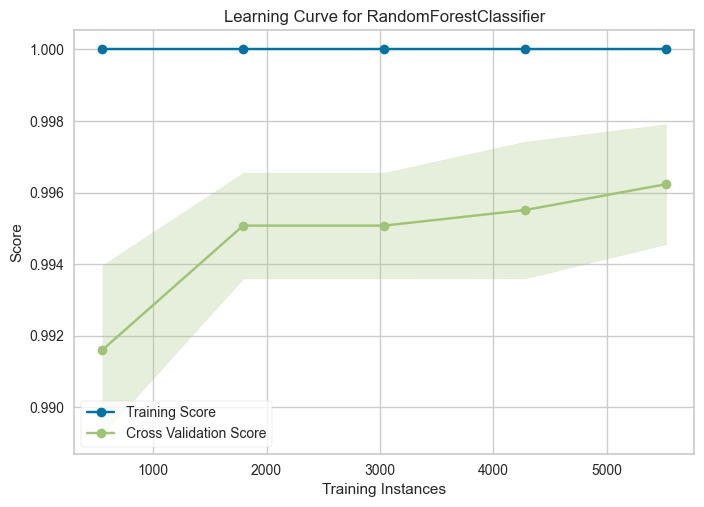

TypeError: cannot unpack non-iterable LearningCurve object

In [102]:
# Compute training and testing accuracy scores for different training set sizes
train_sizes, train_scores, test_scores = learning_curve(rand_forest, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5))

# Calculate mean accuracy scores for training and testing
mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, mean_train_scores, label='Training Accuracy')
plt.plot(train_sizes, mean_test_scores, label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Random Forest Classifier')
plt.show()

In [99]:
from sklearn.decomposition import PCA, KernelPCA
def visualize_pca(df):
    # Assuming 'df' is your DataFrame with features

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.iloc[:, :-1])

    # Perform PCA
    pca = PCA()
    pca.fit_transform(scaled_data)

    # Explained variance ratios
    explained_var = pca.explained_variance_ratio_
    # Plot explained variance ratios
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.9, align='center', color = 'orange')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio of Principal Components')
    plt.show()
    return pca


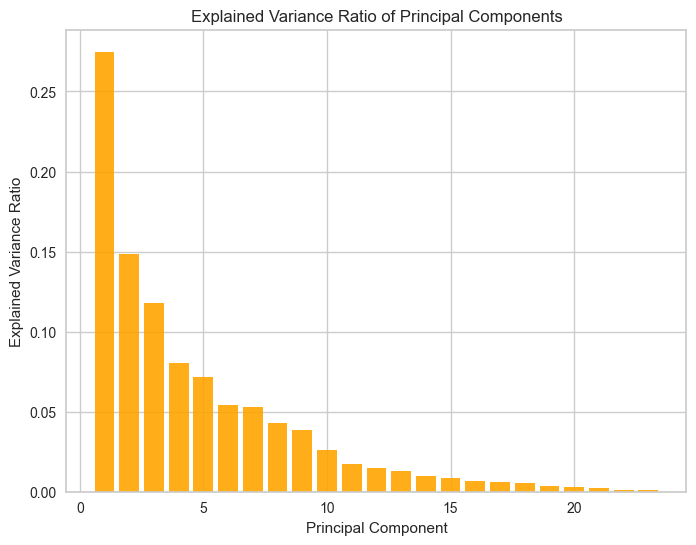

In [100]:
model = visualize_pca(final_df)

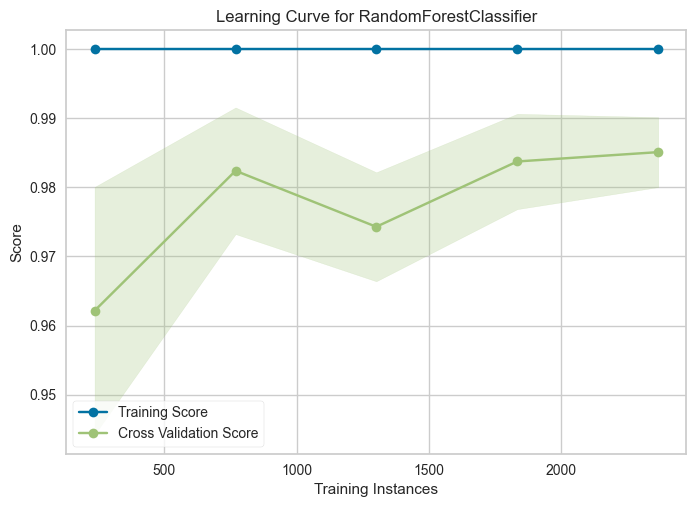

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [101]:
learning_curve(rand_forest, X_test, y_test, scoring='r2')

c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


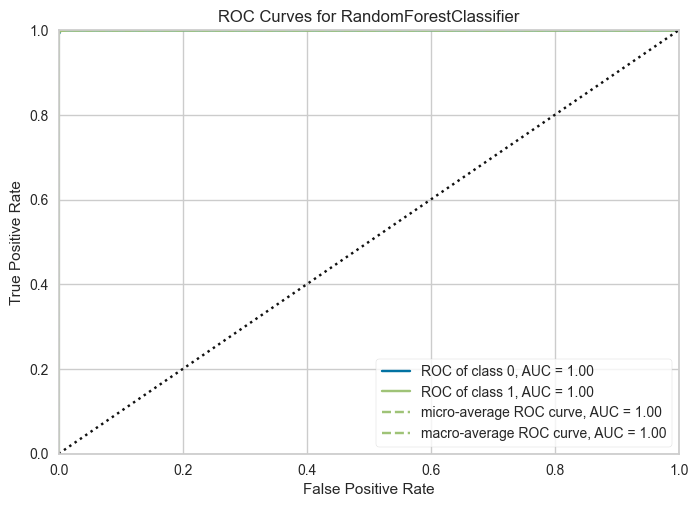

c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


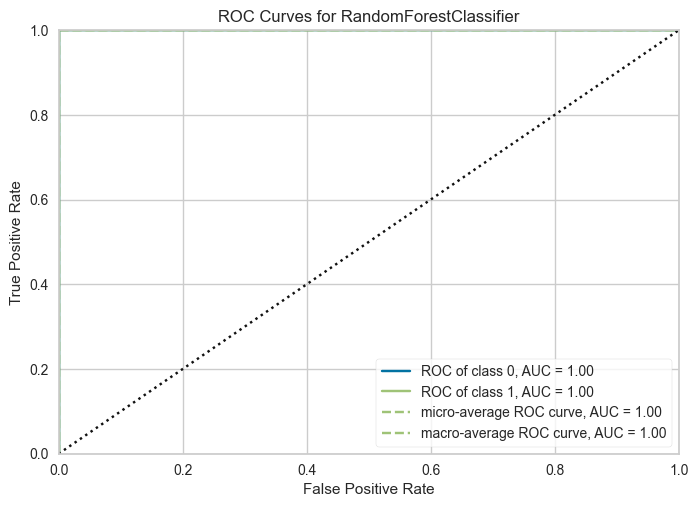

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [11]:
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming you have X_train, X_test, y_train, y_test from the code snippet you provided

# Create the visualizer for test data
visualizer_test = ROCAUC(rand_forest, classes=cls.classes_)
visualizer_test.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_test.score(X_test, y_test)  # Evaluate the model on the test data
visualizer_test.show()  # Show the ROC curve for the test set

# Create the visualizer for train data
visualizer_train = ROCAUC(rand_forest, classes=cls.classes_)
visualizer_train.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_train.score(X_train, y_train)  # Evaluate the model on the train data
visualizer_train.show()  # Show the ROC curve for the train set


In [ ]:
list_cephs = os.listdir('../csv_data/SML/cep/')
list_bin = os.listdir('../csv_data/SML/bin/')[:len(list_cephs)]

# Call function
cephs = data_extraction(src = list_cephs, src_dir = '../csv_data/SML/cep/', object_class = 'Cepheid')
bin = data_extraction(src = list_bin, src_dir = '../csv_data/SML/bin/', object_class = 'Binary')

# Generate DF and show it
test_df = pd.concat([cephs, bin], ignore_index=True)
test_df.to_csv('../csv_data/main_data/lc_data_SML.csv')